
<center>
    <h1>Quantum Dynamic Circuits: IBM Quantum Spring Challenge 2023</h1>
    <br>
    <p style="text-align: center; font-size: 18px;">By: Ahmed Almalki</p>
    <time>May 24, 2023</time>
    <br>
    <a href="https://github.com/asajm/Quantum-Dynamic-Circuits">https://github.com/asajm/Quantum-Dynamic-Circuits</a>
</center>
<hr>

## Introduction

According to the Qiskit textbook _"A quantum circuit is a computational routine consisting of coherent quantum operations on qubits ... It is an ordered sequence of quantum gates, measurements and resets, all of which may be conditioned on and use data from the real-time classical computation."_

You might not be familiar with the last part of the definition, but it has everything to do with dynamic circuits. In this report, we will explore the concept of dynamic circuits and provide demonstrations of three notable examples: Quantum Teleportation, Iterative Phase Estimation, and Quantum Error Correction.

## Dynamic Circuits and Repeat until success

Dynamic circuits are quantum circuits that incorporate mid-circuit measurements, allowing the measurement results to condition subsequent quantum gates within the circuit. This capability to condition future quantum operations based on classical measurement outcomes is commonly referred to as classical feedforward.

The classical feedforward is particularly relevant in scenarios involving the conditional reset operation. Unlike the standard reset operation that sets a qubit to zero regardless of its initial state, the conditional reset utilizes a bit-flip X gate to reset a measured qubit to zero only when its measurement indicates it is in the one state.

<center>
<!-- <img src="resources/sketch-1.png" width="50%"> -->
  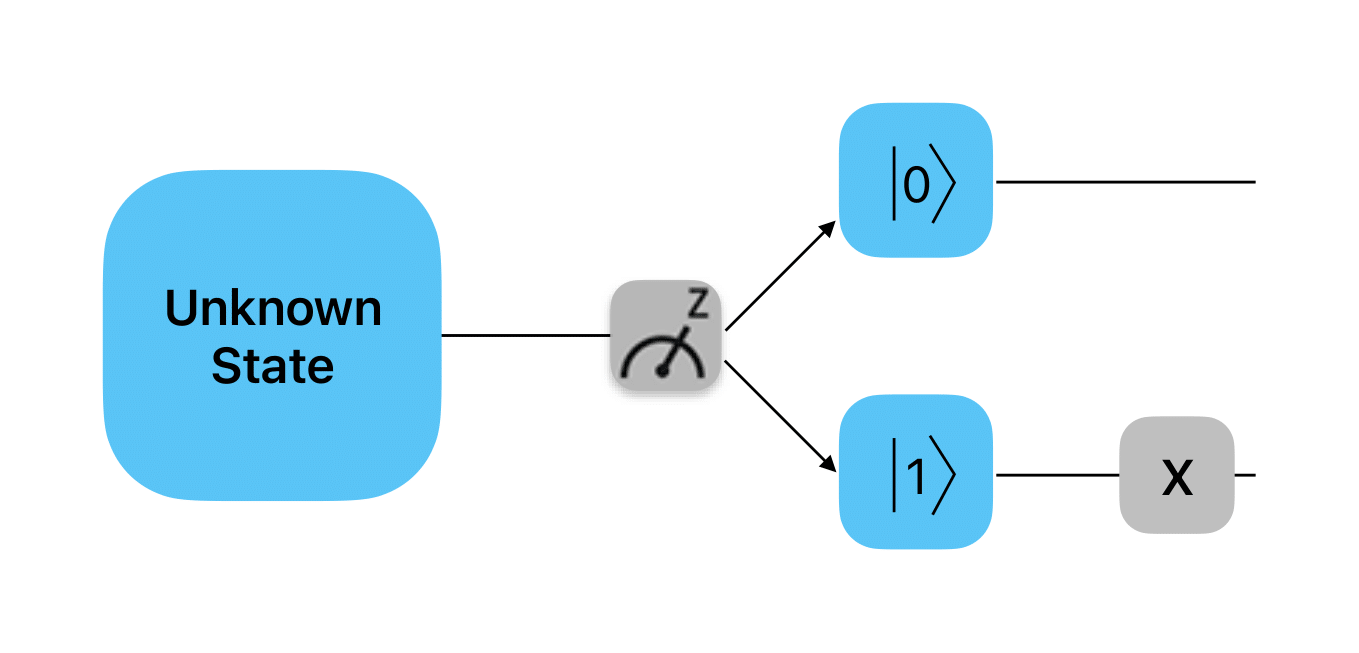

    
</center>

## Quantum Teleportation

Quantum teleportation is a protocol that allows the transfer of quantum information from one qubit to another using entanglement and classical communication. It was proposed by Charles Bennett, Gilles Brassard, Claude Crépeau, Richard Jozsa, Asher Peres, and William Wootters in 1993. The process does not transmit the qubit itself but rather transfers the quantum state from the source qubit to the target qubit.

The protocol requires three qubits:

1. The qubit to be teleported (Alice's qubit)
2. One half of an entangled pair of qubits (Alice's second qubit)
3. The other half of the entangled pair (Bob's qubit)

The protocol can be summarized in the following steps:

1. Create an entangled pair of qubits (Bell pair) shared between Alice and Bob.
2. Alice performs a Bell basis measurement on her two qubits.
3. Alice sends the classical results of her measurement to Bob.
4. Bob applies appropriate quantum gates based on Alice's measurement results to obtain the teleported state.

### Implementation

In order to transfer a quantum bit, Alice and Bob require the help of a third party who provides them with a pair of entangled qubits. Next, Alice carries out certain operations on her qubit and shares the results with Bob through a classical communication channel. Finally, Bob performs a series of operations on his end to successfully obtain Alice's qubit. Now, let's delve deeper into each of these steps.

Our quantum circuit will consist of 3 qubits and 3 classical bits. The qubits will be named as follows:
- $s$: The "source" qubit containing the state $\lvert \psi \rangle$ which Alice wishes to transmit to Bob. Prepare the qubit $q_0$ by applying an $R_x$ rotation with angle $\pi / 4$.
- $a$: The qubit which will initially store Alice's half of the entangled Bell pair.
- $b$: The qubit which will initially store Bob's half of the entangled Bell pair.

The teleportation protocol itself requires 2 classical bits, and we include a third one to use for measuring Bob's final state. The classical bits will be named as follows:
- $c0$: The classical bit that Alice uses to measure $a$.
- $c1$: The classical bit that Alice uses to measure $s$.
- $c2$: The classical bit that Bob uses to measure $b$.

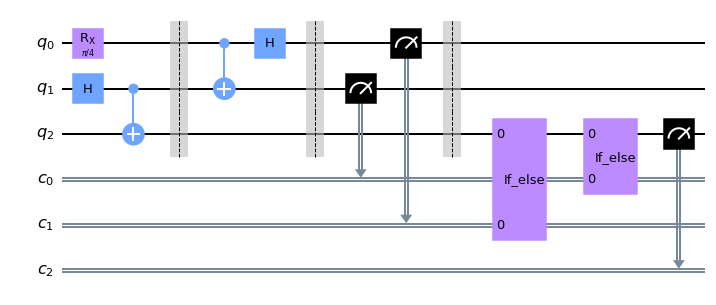

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Qubit, Clbit
import math

def create_bell_pair(qr, cr):
    """Creates a bell pair between qubits a and b."""
    qc = QuantumCircuit(qr, cr)
    _, a, b = qr

    ####### your code goes here #######
    qc.h(a)
    qc.cx(a, b)

    return qc

def alice_gates(qr, cr):
    """Creates Alices's gates"""
    qc = create_bell_pair(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr

    ####### your code goes here #######
    qc.cx(s, a)
    qc.h(s)

    return qc

def measure_and_send(qr, cr):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc = alice_gates(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr
    c0, c1, c2 = cr

    ####### your code goes here #######
    qc.measure(a, c0)
    qc.measure(s, c1)

    return qc

def bob_gates(qr, cr):
    """Uses qc.if_test to control which gates are dynamically added"""
    qc = measure_and_send(qr, cr)
    qc.barrier()  # Use barrier to separate steps
    s, a, b = qr
    c0, c1, c2 = cr

    ####### your code goes here #######
    with qc.if_test((c1, 1)):
        qc.z(b)
    with qc.if_test((c0, 1)):
        qc.x(b)

    return qc


qr = QuantumRegister(3, name="q")
cr = ClassicalRegister(3, name="c")
qc = create_bell_pair(qr, cr)

teleportation_circuit = bob_gates(qr, cr)
s, a, b = qr
c0, c1, c2 = cr
teleportation_circuit.measure(b, c2)


####### your code goes here #######
teleport_superposition_circuit = QuantumCircuit(3, 3)

teleport_superposition_circuit.rx(math.pi/4, 0)
teleport_superposition_circuit = teleport_superposition_circuit.compose(teleportation_circuit)

# Uncomment this line to draw your circuit
teleport_superposition_circuit.draw("mpl", cregbundle=False)

Let's compute the distribution of just Bob's measurement by marginalizing over the other measured bits. The marginal distribution should be somewhat close to the ideal probabilities.

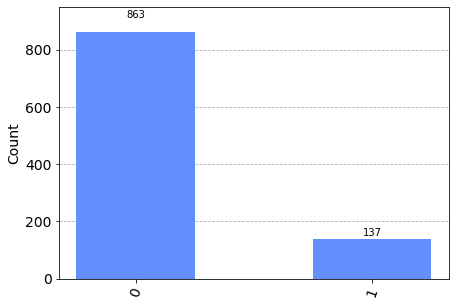

In [9]:
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.result import marginal_counts

sim = AerSimulator()
transpiled_circuit = transpile(teleport_superposition_circuit, sim)

# run job
shots = 1000
job = sim.run(transpiled_circuit, shots=shots, dynamic=True)

# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts()
# plot_histogram(exp_counts)

bobs_counts = marginal_counts(exp_counts, [qr.index(b)])
plot_histogram(bobs_counts)

## Iterative Phase Estimation

The quantum phase estimation (QPE) algorithm is one of the most important and famous quantum algorithms. It is a key subroutine of Shor's factoring algorithm, as well as algorithms for quantum simulation. The textbook version of the algorithm uses a number of auxiliary qubits which scales with the desired precision, leading to circuits that are challenging to execute on today's noisy devices with limited qubit number and connectivity.

Iterative phase estimation (IPE) is a variant of QPE which requires only one auxiliary qubit. In IPE, the auxiliary qubit is repeatedly measured, with the measurement results used to guide future quantum operations. Until the introduction of dynamic circuits, such classical feed-forward was impossible to execute on IBM's quantum hardware.

### Implementation

We will perform IPE on the single-qubit $S$-gate. The $S$ gate is given by the matrix

$$ S =
\begin{pmatrix}
1 & 0\\
0 & e^{i\pi / 2}
\end{pmatrix}$$

We will use the eigenstate $|\Psi\rangle = |1\rangle$, which has eigenvalue $e^{i\pi / 2}= e^{i2\pi \cdot 1/4}$. So we have $\varphi = 1/4 = 0.01 = 0.\varphi_1 \varphi_2$. Since $\varphi$ can be represented exactly with 2 bits, our quantum circuit implementation will use a classical register with two bits to store the result.

The controlled-$S$ gate can be implemented using the controlled phase gate, available in Qiskit as `CPhaseGate`, which can also be applied by calling the `cp` method of a `QuantumCircuit`. The controlled phase gate is parameterized by an angle $\theta$ and has the matrix
$$
        \text{CPhase}(\theta) =
            \begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{i\theta}
            \end{pmatrix}
$$

- **Step 1:** We measure the least significant bit of $\varphi_2$.
- **Step 2:** We extract the next bit $\varphi_1$, which will involve applying a phase correction to cancel out the phase contribution from $\varphi_2$. 

The phase correction depends on the value of the classical register holding $\varphi_2$. We need dynamic circuits to perform this classical feedback! The phase correction can be applied using `PhaseGate` or by directly calling the `p` method of a QuantumCircuit.

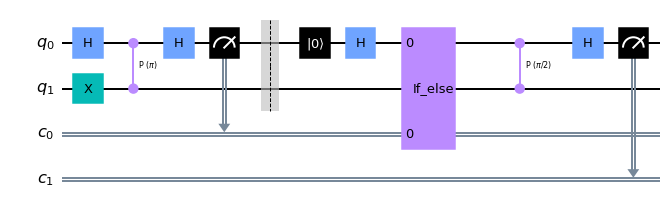

In [37]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import numpy as np
import math

def step_1_circuit(qr, cr):
    qc = QuantumCircuit(qr, cr)

    ####### your code goes here #######
    qr0, qr1 = qr
    cr0, cr1 = cr
    qc.h(qr0)
    qc.x(qr1)
    qc.cp(math.pi, qr0, qr1)
    qc.h(0)
    qc.measure(qr0, cr0)

    return qc

def step_2_circuit(qr, cr):
    qc = step_1_circuit(qr, cr)

    ####### your code goes here #######
    qc.barrier()
    qr0, qr1 = qr
    cr0, cr1 = cr
    qc.reset(qr0)
    qc.h(qr0)
    
    with qc.if_test((cr0, 1)):
        # qc.p(math.pi, qr0)
        qc.p(-math.pi/2, qr0)
        
    qc.cp(math.pi/2, qr0, qr1)
    qc.h(qr0)
    qc.measure(qr0, cr1) 
    
    return qc

qr = QuantumRegister(2, "q")
cr = ClassicalRegister(2, "c")
qc = QuantumCircuit(qr, cr)
qc = step_2_circuit(qr, cr)
qc.draw("mpl")

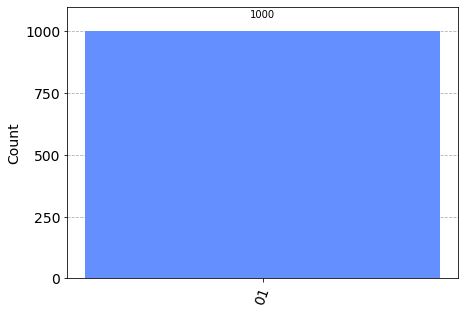

In [38]:
from qiskit_aer import AerSimulator

sim = AerSimulator()
job = sim.run(qc, shots=1000)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)
# counts

We have gotten the bitstring `01` with 100% probability. This value corresponds to the phase written in binary as $\varphi = 0.01 = 1/4$.

## Quantum Error Correction

Dynamic circuits also have the potential to greatly help with error correction on quantum computers. Error correction is important for quantum computing, since physical qubits are susceptible to noise. This means we will always have some small probability that errors occur when running our circuits. Error correction will help us deal with those small probabilities and ensure we get the correct results in the end, by correcting the errors as they occur.

### Implementation (Bit-flip Repetition Code)

Let’s prepare everything such that we can start with implementing the error correction.

- **Initializing the Qubit:** Prepare the physical state $|\Psi_1\rangle = |1\rangle$
- **Encoding the Qubit:** Map our state $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$ using our encoding $U_{en}|\Psi_0\rangle$ to the state $ (\alpha |000\rangle + \beta |111\rangle)$.
- **Measuring Stabilizers:** Compute syndrome bits, such that they can be measured to detect single bitflip errors.
    - `00` -> No error occurred 
    - `01` -> An error occurred  in qubit 0 (the first qubit)
    - `10` -> An error occurred  in qubit 1 (the second qubit)
    - `11` -> An error occurred  in qubit 2 (the third qubit)
- **Correcting Errors:** Correct the errors according to the measured syndromes.
- **Decoding Circuit:** Use our decoding $U_{de}|\Psi_0\rangle$ which maps $ (\alpha |000\rangle + \beta |111\rangle)$ to   $|\Psi_1\rangle = (\alpha |0\rangle + \beta |1\rangle)$. 

_Hint: $U_{de} = U_{en}^\dagger$_

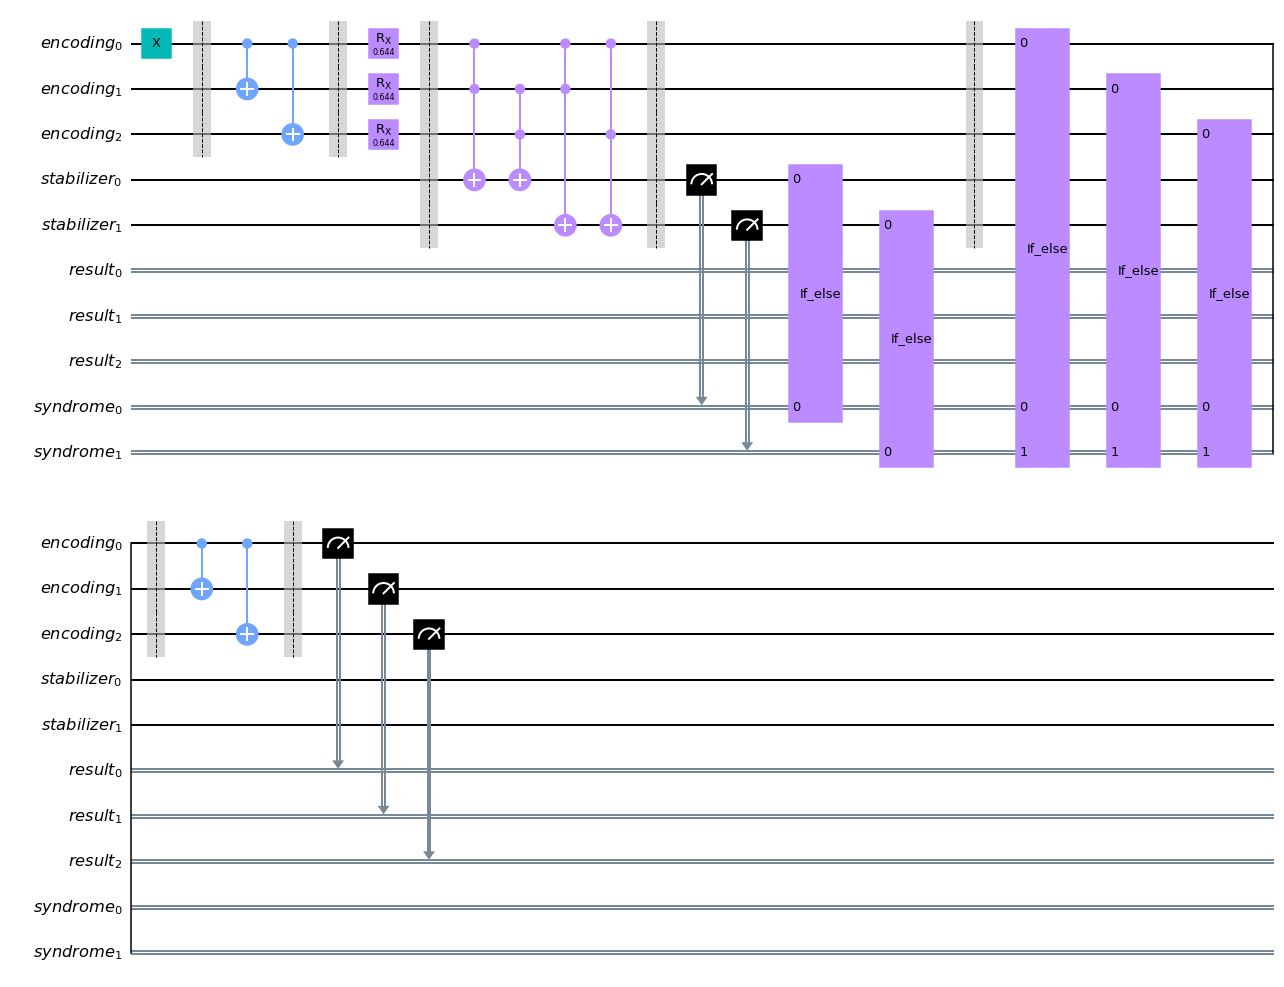

In [39]:
# Setup a base quantum circuit for our experiments
encoding = QuantumRegister(3, 'encoding')
stabilizer = QuantumRegister(2, 'stabilizer')

encoding_q0, encoding_q1, encoding_q2 = encoding
stabilizer_q0, stabilizer_q1 = stabilizer

# Results of the encoding
results = ClassicalRegister(3, 'result')

result_b0, result_b1, result_b2 = results

# For measuring the stabilizer
syndrome = ClassicalRegister(2, 'syndrome')

syndrome_b0, syndrome_b1 = syndrome

# The actual qubit which is encoded
state = encoding[0]

# The ancillas used for encoding the state
ancillas = encoding[1:]


# Initializing
def initialize_circuit():
    return QuantumCircuit(encoding, stabilizer, results, syndrome)

# Encoding using bit flip code
def encode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc

# Decoding (doing the reverse)
def decode_bit_flip(qc, state, ancillas):
    qc.barrier(state, *ancillas)
    for ancilla in ancillas:
        qc.cx(state, ancilla)
    return qc

def measure_syndrome_bit(qc, encoding, stabilizer):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding
    stabilizer_q0, stabilizer_q1 = stabilizer

    ####### your code goes here #######
    qc.ccx(encoding_q0, encoding_q1, stabilizer_q0)
    qc.ccx(encoding_q1, encoding_q2, stabilizer_q0)
    qc.ccx(encoding_q0, encoding_q1, stabilizer_q1)
    qc.ccx(encoding_q0, encoding_q2, stabilizer_q1)

    ####### don't edit the code below #######
    qc.barrier()
    qc.measure(stabilizer, syndrome)
    with qc.if_test((syndrome_b0, 1)):
        qc.x(stabilizer_q0)
    with qc.if_test((syndrome_b1, 1)):
        qc.x(stabilizer_q1)

    return qc

# Correct the errors, remember how we encoded the errors above!
def apply_correction_bit(qc, encoding, syndrome):
    qc.barrier()
    encoding_q0, encoding_q1, encoding_q2 = encoding

    ####### your code goes here #######
    with qc.if_test((syndrome_b0, 1)):
        with qc.if_test((syndrome_b1, 0)):
            qc.x(encoding_q0)
    with qc.if_test((syndrome_b0, 0)):
        with qc.if_test((syndrome_b1, 1)):
            qc.x(encoding_q1)
    with qc.if_test((syndrome_b0, 1)):
        with qc.if_test((syndrome_b1, 1)):
            qc.x(encoding_q2)
    
    return qc

def apply_final_readout(qc, encoding, results):
    qc.barrier(encoding)
    qc.measure(encoding, results)
    return qc

def make_some_noise(qc, encoding, syndrome, error_percentage):
    encoding_q0, encoding_q1, encoding_q2 = encoding
    syndrome_b0, syndrome_b1 = syndrome

    ####### your code goes here #######
    qc.barrier(encoding)
    err_perc = 0.1
    theta = 2 * math.asin(math.sqrt(err_perc))
    qc.rx(theta, encoding_q0)
    qc.rx(theta, encoding_q1)
    qc.rx(theta, encoding_q2)

    return qc

initial_state = initialize_circuit()
initial_state.x(encoding[0])

encoding_circuit = encode_bit_flip(initialize_circuit(), state, ancillas)
syndrome_circuit = measure_syndrome_bit(initialize_circuit(), encoding, stabilizer)
correction_circuit = apply_correction_bit(initialize_circuit(), encoding, syndrome)
decoding_circuit = decode_bit_flip(initialize_circuit(), state, ancillas)
measuring_circuit = apply_final_readout(initialize_circuit(), encoding, results)

noise_circuit = make_some_noise(initialize_circuit(), encoding, syndrome, 10)

complete_circuit = (
    initial_state.compose(encoding_circuit)
    .compose(noise_circuit)
    .compose(syndrome_circuit)
    .compose(correction_circuit)
    .compose(decoding_circuit)
    .compose(measuring_circuit)
)
complete_circuit.draw(output="mpl")


## Conclusion

The dynamic circuits are crucial for expanding the capabilities of quantum computing and opens up new avenues for quantum algorithm design, error mitigation, and optimization. Additionally, dynamic circuits allow for efficient utilization of quantum resources and enhance the overall performance of quantum computations. 

The IBM Quantum Challenge offers participants hands-on experience using real quantum hardware, promoting collaboration and inclusivity. It provides valuable learning opportunities, exposure to quantum technologies, and contributes to the advancement of quantum computing research and development.